## Load Encoded Captions

In [25]:
import h5py
from os.path import join
import numpy as np
import random
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

/home/tingwenbao/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [2]:
data_dir = 'Data'
h = h5py.File(join(data_dir, 'flower_tv.hdf5'))

In [3]:
flower_captions = {}
for ds in h.iteritems():
    flower_captions[ds[0]] = np.array(ds[1])

In [4]:
# each image has 5 captions each vectorized into 4800 vectors
flower_captions['image_05349.jpg']

array([[  1.12434858e-02,  -1.09033026e-02,  -5.40558062e-03, ...,
          4.71095368e-03,   3.07553913e-03,  -7.88170006e-03],
       [  5.23057580e-03,  -1.70876943e-02,  -5.15448023e-03, ...,
          1.07166674e-02,   1.85983779e-03,  -2.78546521e-03],
       [  2.36820132e-02,  -7.51516828e-03,  -5.73695637e-03, ...,
          6.86524883e-02,   1.42409978e-03,  -1.04672341e-02],
       [  3.76328523e-03,   2.30614142e-03,  -4.49462328e-03, ...,
         -1.71718730e-05,   2.64344364e-03,  -8.79086379e-04],
       [  1.11399777e-02,  -4.91742557e-03,  -8.57677124e-03, ...,
          6.91645890e-02,   1.77751575e-03,  -6.18656259e-03]], dtype=float32)

## How to create embedding with a new sentence

In [5]:
import imp
imp.load_source("skipthoughts", "./skip-thoughts/skipthoughts.py") 
import skipthoughts

model = skipthoughts.load_model()
encoder = skipthoughts.Encoder(model)


WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


In [50]:
vectors = encoder.encode(["Hello World!", "how are you"],verbose=False)

In [51]:
vectors

array([[ 0.00289424, -0.01340303, -0.0031364 , ..., -0.00020494,
         0.00080485, -0.00859977],
       [ 0.00222143, -0.01256226, -0.01843037, ..., -0.00421009,
         0.01834103, -0.01412064]], dtype=float32)

## Prep Inputs For GAN

In [8]:
def load_training_data(data_dir, data_set='flowers'):
	if data_set == 'flowers':
		h = h5py.File(join(data_dir, 'flower_tv.hdf5'))
		flower_captions = {}
		for ds in h.iteritems():
			flower_captions[ds[0]] = np.array(ds[1])
		image_list = [key for key in flower_captions]
		image_list.sort()

		img_75 = int(len(image_list)*1) # can be changed if don't need all pic
		training_image_list = image_list[0:img_75]
		#random.shuffle(training_image_list)
		
		return {
			'image_list' : training_image_list,
			'captions' : flower_captions,
			'data_length' : len(training_image_list)
		}

flower_cap = load_training_data(data_dir)

In [9]:
print flower_cap['image_list'][0]
print flower_cap['captions'][flower_cap['image_list'][0]]
print flower_cap['data_length']

image_00001.jpg
[[ 0.00247043 -0.00978464 -0.01372992 ..., -0.02817912  0.03375437
  -0.00589225]
 [ 0.01244221 -0.01928648 -0.00613386 ..., -0.0065219   0.00466952
  -0.01222099]
 [ 0.01298153 -0.00059234 -0.00383552 ...,  0.02389688  0.00137579
  -0.01621519]
 [ 0.00446556 -0.0084612  -0.00732049 ...,  0.00601037  0.00218833
   0.00555609]
 [ 0.01124559 -0.0070828  -0.0034986  ..., -0.02691613  0.0067353
  -0.00037385]]
8189


In [10]:
def load_image_array(image_file, image_size):
    img = skimage.io.imread(image_file)
    # GRAYSCALE
    if len(img.shape) == 2:
        img_new = np.ndarray( (img.shape[0], img.shape[1], 3), dtype = 'uint8')
        img_new[:,:,0] = img
        mg_new[:,:,1] = img
        img_new[:,:,2] = img
        img = img_new

    img_resized = skimage.transform.resize(img, (image_size, image_size))
    
    return img_resized.astype('float32')
    

/home/tingwenbao/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


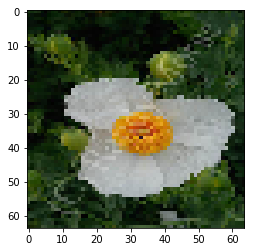

In [11]:

dir_img = join('Data/flowers/jpg', 'image_05306.jpg')
im = load_image_array(dir_img, 64)
plt.imshow(im)


In [12]:
#Compile training dataset: ID, Image (X), Embedding (Y)
img_id = flower_cap['image_list']
Y = np.zeros((flower_cap['data_length']*5,4800))
X= np.zeros((flower_cap['data_length'],64,64,3))
n=0

for i in img_id:
    for c in range(0,5):
        Y[(n*5+c),:] = flower_cap['captions'][i][c]
    X[n,:,:,:] = load_image_array(join('Data/flowers/jpg', i), 64)
    n += 1

In [15]:
print X.shape
print Y.shape

(8189, 64, 64, 3)
(40945, 4800)


## Conditional GAN

In [56]:
# Hyperparameters
mb_size = 128
num_epochs = 30
Z_dim = 100
image_size = 64
label_size = len(flower_cap['captions'][flower_cap['image_list'][0]][0])  #4800 for skip-thought
D_learning_rate = 0.001
G_learning_rate = 0.0005

# Helper Functions
def plot(samples):
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64))

    return fig


def generate_a_graph(i,j): # generate image by label
    label_y = np.random.uniform(0, 0, size=[1, label_size])
    label_y[0,:] = label_test[i]
        
    z = np.random.uniform(-1., 1., size=[1, Z_dim])
    g = sess.run(G_sample, feed_dict={Z_ph: z, Y_real:label_y})
    return (g.reshape(image_size, image_size,3))

In [42]:
def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])

def batch_iter(data, label, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_true_indices = np.random.permutation(np.arange(data_size))
            shuffle_false_indices = np.random.permutation(np.arange(data_size)) # need to check this
        else:
            shuffle__true_indices = range(0, data_size)
        for batch_num in range(num_batches_per_epoch):
            random_caption_index = random.randint(0,4) # random selection of one of the 5 caption each batch
            shuffle_true_label_index = [x+random_caption_index for x in shuffle_true_indices]
            shuffle_false_label_index = [x+random_caption_index for x in shuffle_false_indices]
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            image_true =  data[shuffle_true_indices[start_index:end_index]]
            #image_false = data[shuffle_false_indices[start_index:end_index]]
            label_true = label[shuffle_true_label_index[start_index:end_index]]
            label_false = label[shuffle_false_label_index[start_index:end_index]]
            yield (image_true, label_true, label_false)

In [29]:
# Construct the conditional GAN

tf.reset_default_graph()

def xavier_init(size):
    return tf.random_normal(shape=size, stddev=(1. / tf.sqrt(size[0] / 2.)))

def generator(z, y):
    z_y = tf.concat([z, y], 1)
    G_h1 = tf.nn.relu(tf.matmul(z_y, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

def discriminator(x, y):
    x_y = tf.concat([x, y], 1)
    D_h1 = tf.nn.relu(tf.matmul(tf.contrib.layers.flatten(x_y), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit


# Discriminator Net
X_ph = tf.placeholder(tf.float32, shape=[None, (image_size*image_size*3)], name='X')
Y_real = tf.placeholder(tf.float32, shape=[None, label_size], name='Y_real')
Y_fake = tf.placeholder(tf.float32, shape=[None, label_size], name='Y_fake')

D_W1 = tf.Variable(xavier_init([(image_size*image_size*3+label_size), 256]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[256]), name='D_b1')

D_W2 = tf.Variable(xavier_init([256, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]


# Generator Net
Z_ph = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')

G_W1 = tf.Variable(xavier_init([Z_dim+label_size, 256]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[256]), name='G_b1')

G_W2 = tf.Variable(xavier_init([256, (image_size*image_size*3) ]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[(image_size*image_size*3)]), name='G_b2')

theta_G = [G_W1, G_W2, G_b1, G_b2]


# losses and MaxMin
G_sample = generator(Z_ph, Y_real)
D_real, D_logit_real = discriminator(X_ph, Y_real)
D_fake, D_logit_fake = discriminator(G_sample,Y_real)
D_real_fake, D_logit_real_fake = discriminator(X_ph, Y_fake)

D_loss = -tf.reduce_mean(tf.log(D_real) + (tf.log(1. - D_fake) + tf.log(1. - D_real_fake))/2)
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer(D_learning_rate,beta1=0.5).minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer(G_learning_rate,beta1=0.5).minimize(G_loss, var_list=theta_G)



Iter: 1
D loss: 1.415
G_loss: 1.159
()


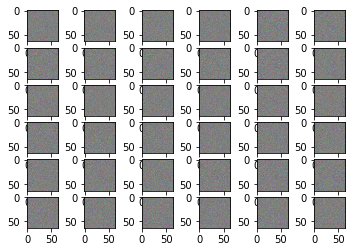

Iter: 1000
D loss: nan
G_loss: nan
()


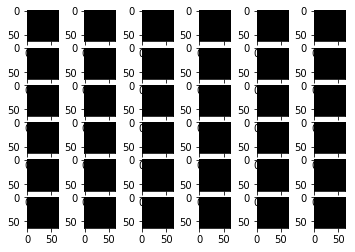

KeyboardInterrupt: 

In [57]:
## Run the conditional GAN model

# define global steps 
global_step = tf.Variable(0, name="global_step", trainable=False)
incr_global_step_op = tf.assign(global_step, global_step+1)

# define test label 
caption = [
    'the flower shown has yellow anther red pistil and bright red petals',
    'this flower has petals that are yellow, white and purple and has dark lines',
    'the petals on this flower are white with a yellow center',
    'this flower has a lot of small round pink petals.',
    'this flower is orange in color, and has petals that are ruffled and rounded.',
    'the flower has yellow petals and the center of it is brown']
label_test = encoder.encode(caption,verbose=False)

# start tf session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

# initialize loss
D_loss_c = []
G_loss_c = []

# Run in mini batch
batches = batch_iter(X, Y, mb_size, num_epochs)

for image_true, label_true, label_false in batches:
    
    _, D_loss_curr, _, G_loss_curr, i = sess.run([D_solver, D_loss, G_solver, G_loss, incr_global_step_op]
                                                 ,feed_dict={X_ph: image_true.reshape([-1,(image_size*image_size*3)])
                                                             , Y_real: label_true
                                                             , Y_fake: label_false
                                                             , Z_ph:sample_Z(image_true.shape[0], Z_dim)
                                                             })
    # print some loss during the training
    if i % 1000 == 0 or i==1:
        print('Iter: {}'.format(i))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        D_loss_c.append(D_loss_curr)
        G_loss_c.append(G_loss_curr)
        
    # generate plot with set label during the training    
    if i % 1000 == 0 or i==1:
        f, axarr = plt.subplots(6,6)
        for n in range(6):
            for m in range(6):
                im = generate_a_graph(n,m)
                axarr[n,m].imshow(im)
        plt.show()